In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ipywidgets
from scipy.fftpack import fft,fftfreq
from scipy.signal import welch,find_peaks
from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [ ]:
%matplotlib inline
rcParams = {
    "ytick.color": "k",
    "xtick.color": "k",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "axes.labelcolor": "k",
    "axes.edgecolor": "k",
    # 'text.color' : "k",
    "figure.dpi": 90
}
plt.rcParams.update(rcParams)

In [ ]:
# defining functions to read data and labels
def extract_measurements(filename):
    with open(filename,'r') as f:
        data = f.read().splitlines()
        data = map(lambda x: x.strip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype = np.float32())
    return data

def extract_labels(filename):
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = np.array(list(map(int, activities)))
    return activities

def randomize_data(dataset, labels):
    perm = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[perm, :, :]
    shuffled_labels = labels[perm]
    return shuffled_dataset, shuffled_labels

In [ ]:
#defining paths
train_path = '/content/drive/MyDrive/HAR SmartPhone/UCI HAR Dataset/train/Inertial Signals'
test_path = '/content/drive/MyDrive/HAR SmartPhone/UCI HAR Dataset/test/Inertial Signals'

trainlabel_path = '/content/drive/MyDrive/HAR SmartPhone/UCI HAR Dataset/train/y_train.txt'
testlabel_path  = '/content/drive/MyDrive/HAR SmartPhone/UCI HAR Dataset/test/y_test.txt'


In [ ]:
#getting file names and their paths
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

train_file_path = np.sort(glob('/content/drive/MyDrive/HAR SmartPhone/UCI HAR Dataset/train/Inertial Signals/*.txt',recursive = True))

test_file_path = np.sort(glob('/content/drive/MyDrive/HAR SmartPhone/UCI HAR Dataset/test/Inertial Signals/*.txt',recursive = True))


In [ ]:
# extract train and test data
train_data, test_data = [],[]

for file in train_file_path:
    data = extract_measurements(file)
    train_data.append(data)

train_data = np.transpose(np.array(train_data),(1,2,0))

for file in test_file_path:
    data = extract_measurements(file)
    test_data.append(data)

test_data = np.transpose(np.array(test_data),(1,2,0))

# extract labels
train_labels = extract_labels(trainlabel_path)
test_labels = extract_labels(testlabel_path)

#randomize train and test datasets
train_data, train_labels = randomize_data(train_data, train_labels)
test_data, test_labels = randomize_data(test_data, test_labels)

In [ ]:
#All data is extracted using numpy array
print(train_data.shape) # (7352, 128, 9); Here 7352 is the number of sample collected,
print(train_data.dtype) # float32
print(test_data.shape) # (2947, 128, 9)
print(test_data.dtype) # float32
# the label_map = {1:'WALKING', 2:'WALKING UP', 3:'WALKING DOWN', 4:'SITTING', 5:'STANDING', 6:'LAYING'}
print(train_labels.shape) # (7352,)
print(train_labels.dtype) # int64
print(test_labels.shape) # test_labels
print(test_labels.dtype) # int64

(7352, 128, 9)
float32
(2947, 128, 9)
float32
(7352,)
int64
(2947,)
int64


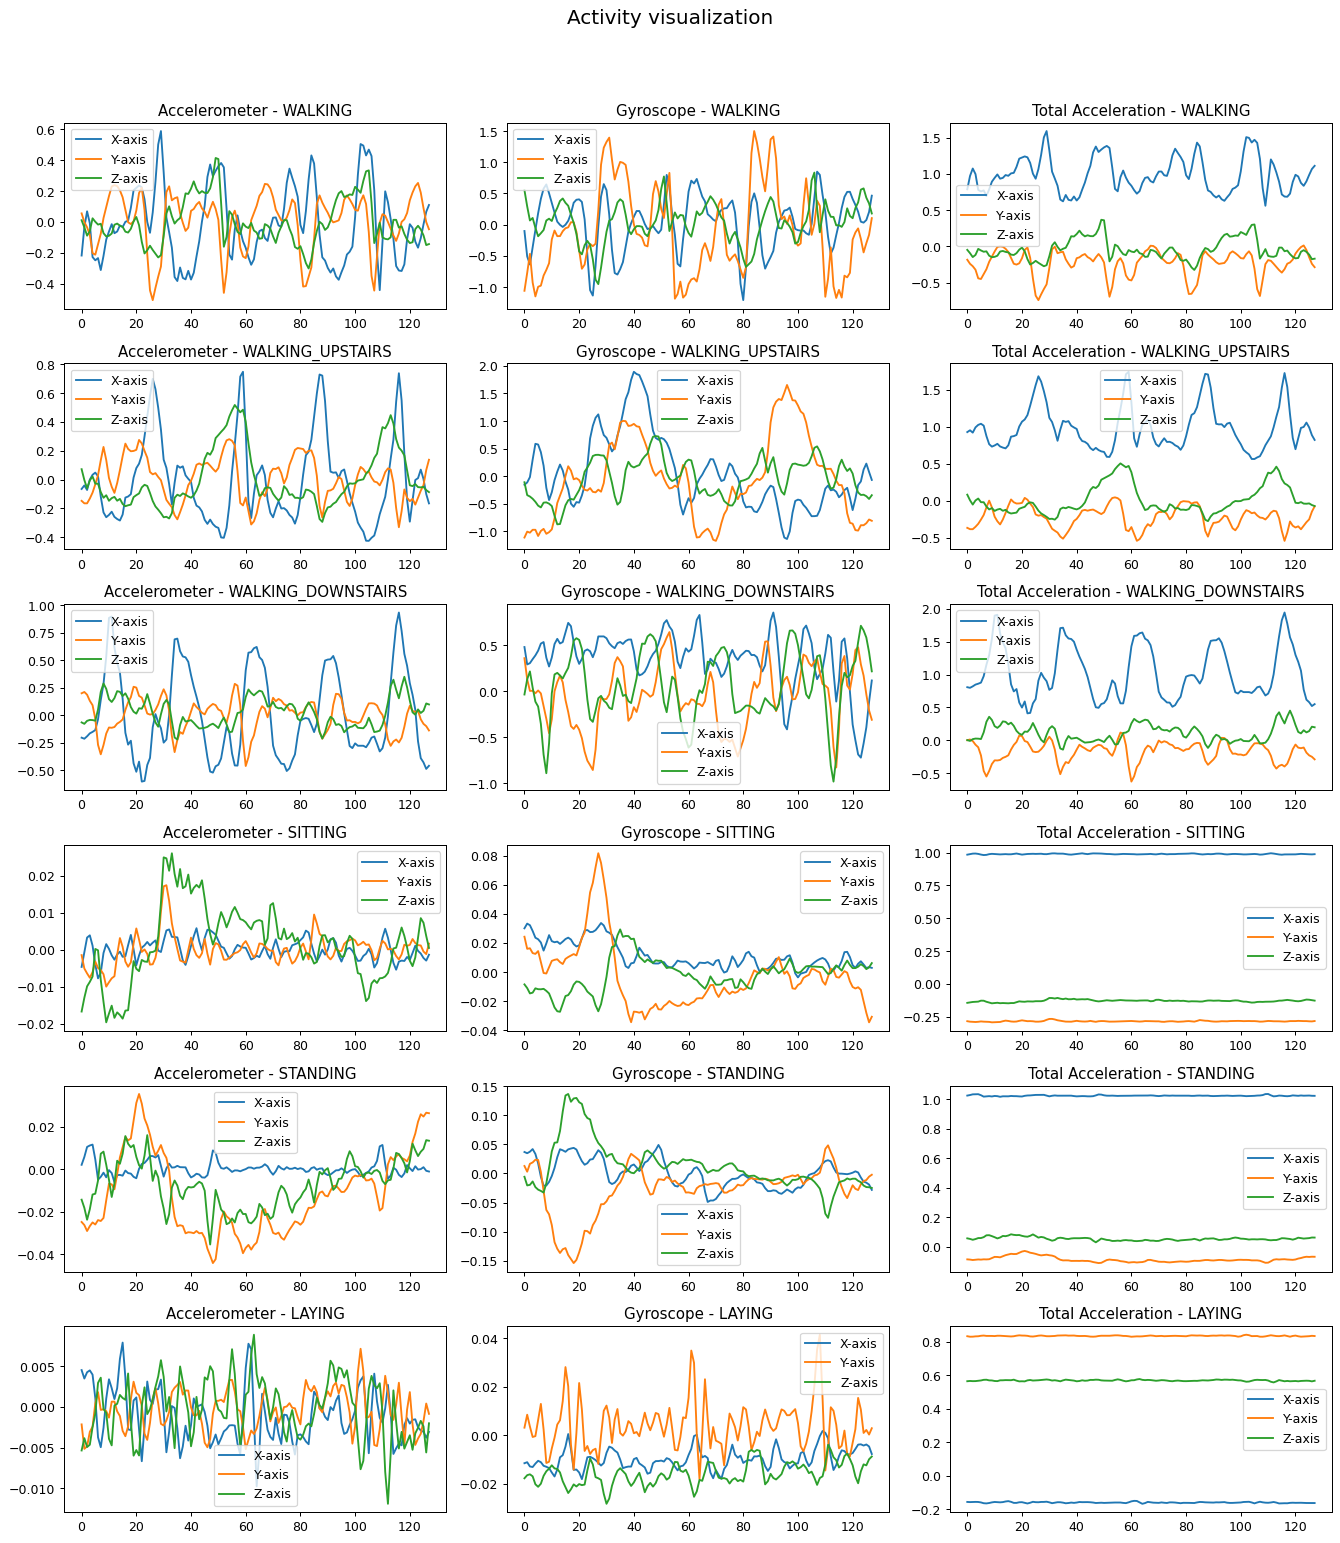

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have train_data and train_labels loaded

# Define label map
label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
             4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

# Choose a random sample index for each activity
activity_indices = []
for i in range(6):
    for sample in range(1000):
        if train_labels[sample] == i + 1:
            activity_indices.append(sample)
            break

# Plot accelerometer, gyroscope, and total acceleration data
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 18))
fig.suptitle("Activity visualization", fontsize=16)
for i, sample_index in enumerate(activity_indices):
    activity_label = label_map[i + 1]

    # Accelerometer Data
    axes[i, 0].plot(train_data[sample_index, :, 0], label='X-axis')
    axes[i, 0].plot(train_data[sample_index, :, 1], label='Y-axis')
    axes[i, 0].plot(train_data[sample_index, :, 2], label='Z-axis')
    axes[i, 0].set_title(f'Accelerometer - {activity_label}')
    axes[i, 0].legend()

    # Gyroscope Data
    axes[i, 1].plot(train_data[sample_index, :, 3], label='X-axis')
    axes[i, 1].plot(train_data[sample_index, :, 4], label='Y-axis')
    axes[i, 1].plot(train_data[sample_index, :, 5], label='Z-axis')
    axes[i, 1].set_title(f'Gyroscope - {activity_label}')
    axes[i, 1].legend()

    # Total Acceleration Data
    axes[i, 2].plot(train_data[sample_index, :, 6], label='X-axis')
    axes[i, 2].plot(train_data[sample_index, :, 7], label='Y-axis')
    axes[i, 2].plot(train_data[sample_index, :, 8], label='Z-axis')
    axes[i, 2].set_title(f'Total Acceleration - {activity_label}')
    axes[i, 2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


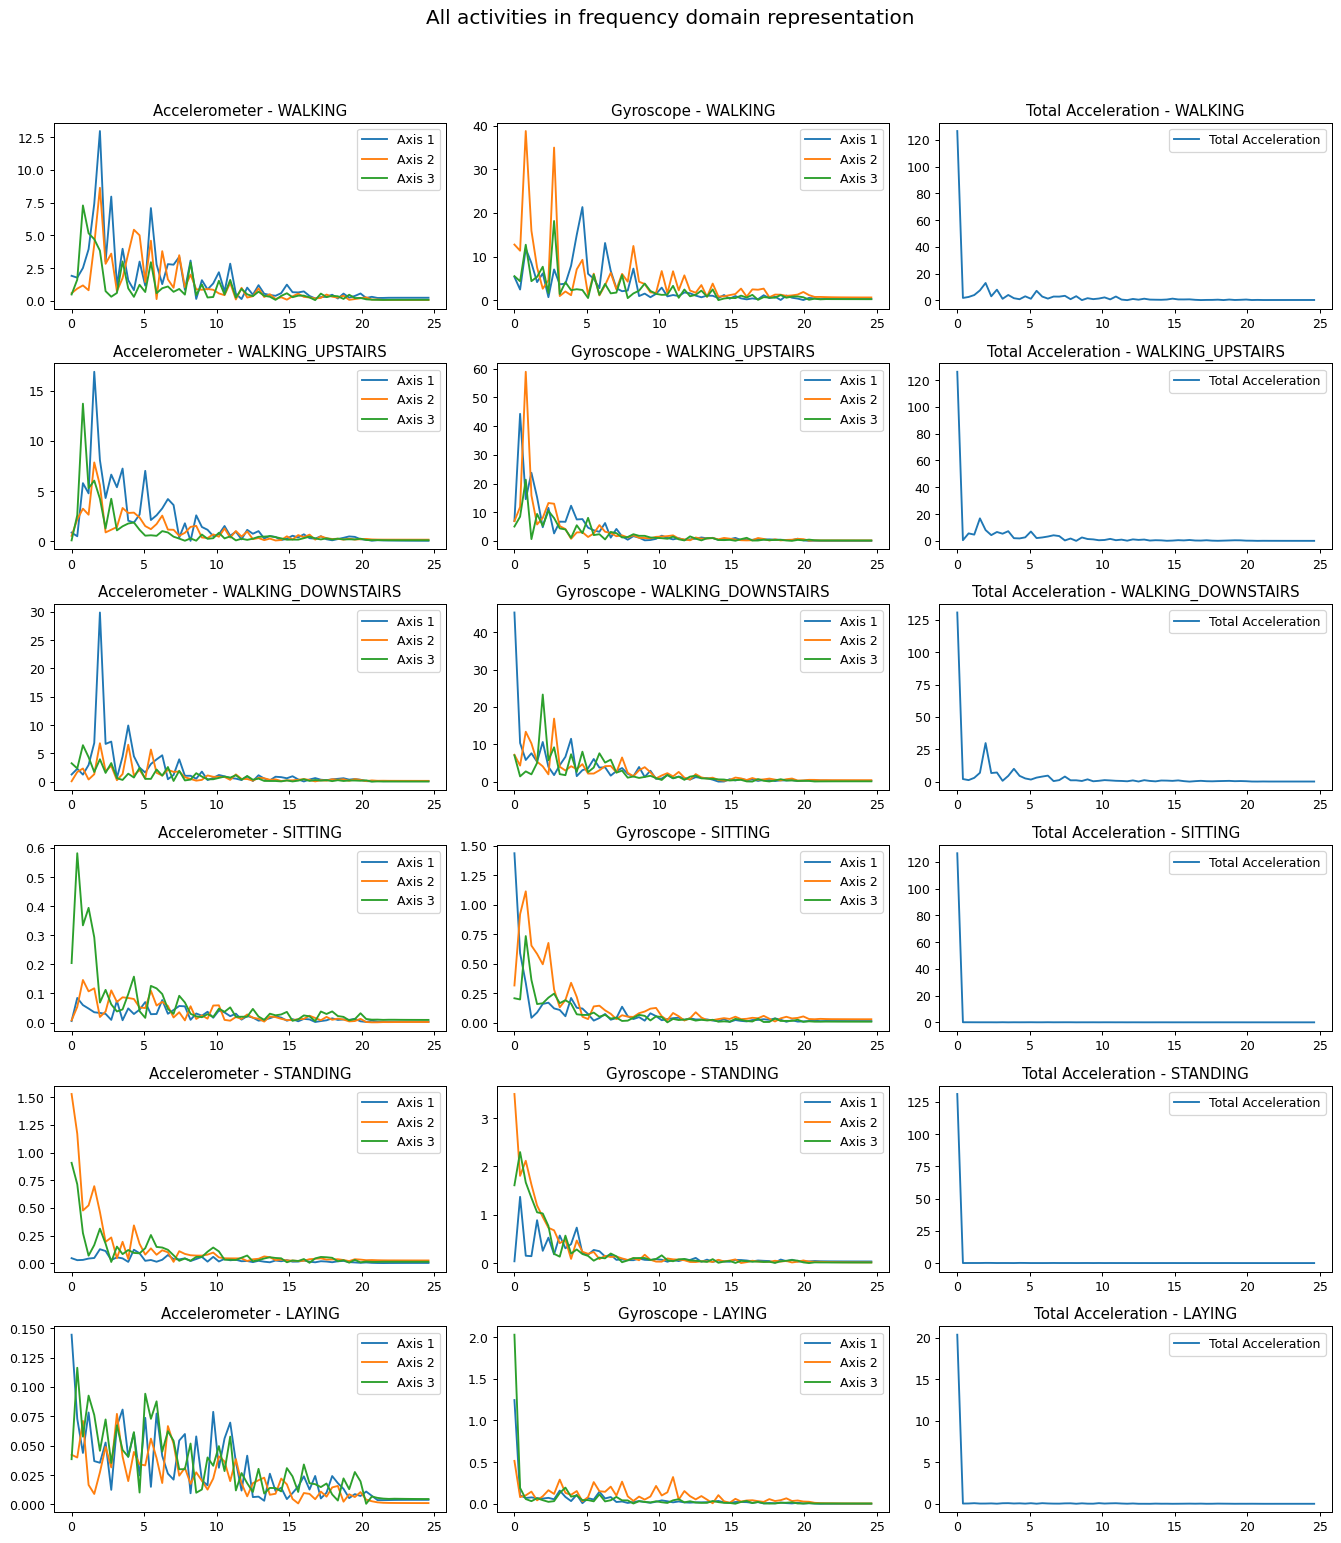

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import seaborn as sns

# Assuming you have train_data and train_labels loaded

# Define label map
label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
             4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

# Choose a random sample index for each activity
activity_indices = []
for i in range(6):
    for sample in range(1000):
        if train_labels[sample] == i + 1:
            activity_indices.append(sample)
            break

# Perform FFT and plot frequency-domain signals
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 18))
fig.suptitle("All activities in frequency domain representation", fontsize=16)
for i, sample_index in enumerate(activity_indices):
    activity_label = label_map[i + 1]

    # Accelerometer Data - Frequency Domain
    axes[i, 0].set_title(f'Accelerometer - {activity_label}')
    for axis in range(3):
        signal = train_data[sample_index, :, axis]
        freq_domain = np.fft.fft(signal)
        frequencies = np.fft.fftfreq(len(signal), d=1/50)  # Assuming data collected in 50Hz format
        axes[i, 0].plot(frequencies[:len(frequencies)//2], np.abs(freq_domain)[:len(frequencies)//2], label=f'Axis {axis+1}')
    axes[i, 0].legend()

    # Gyroscope Data - Frequency Domain
    axes[i, 1].set_title(f'Gyroscope - {activity_label}')
    for axis in range(3):
        signal = train_data[sample_index, :, axis + 3]
        freq_domain = np.fft.fft(signal)
        frequencies = np.fft.fftfreq(len(signal), d=1/50)  # Assuming data collected in 50Hz format
        axes[i, 1].plot(frequencies[:len(frequencies)//2], np.abs(freq_domain)[:len(frequencies)//2], label=f'Axis {axis+1}')
    axes[i, 1].legend()

    # Total Acceleration - Frequency Domain
    axes[i, 2].set_title(f'Total Acceleration - {activity_label}')
    signal = train_data[sample_index, :, 6]
    freq_domain = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1/50)  # Assuming data collected in 50Hz format
    axes[i, 2].plot(frequencies[:len(frequencies)//2], np.abs(freq_domain)[:len(frequencies)//2], label='Total Acceleration')
    axes[i, 2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


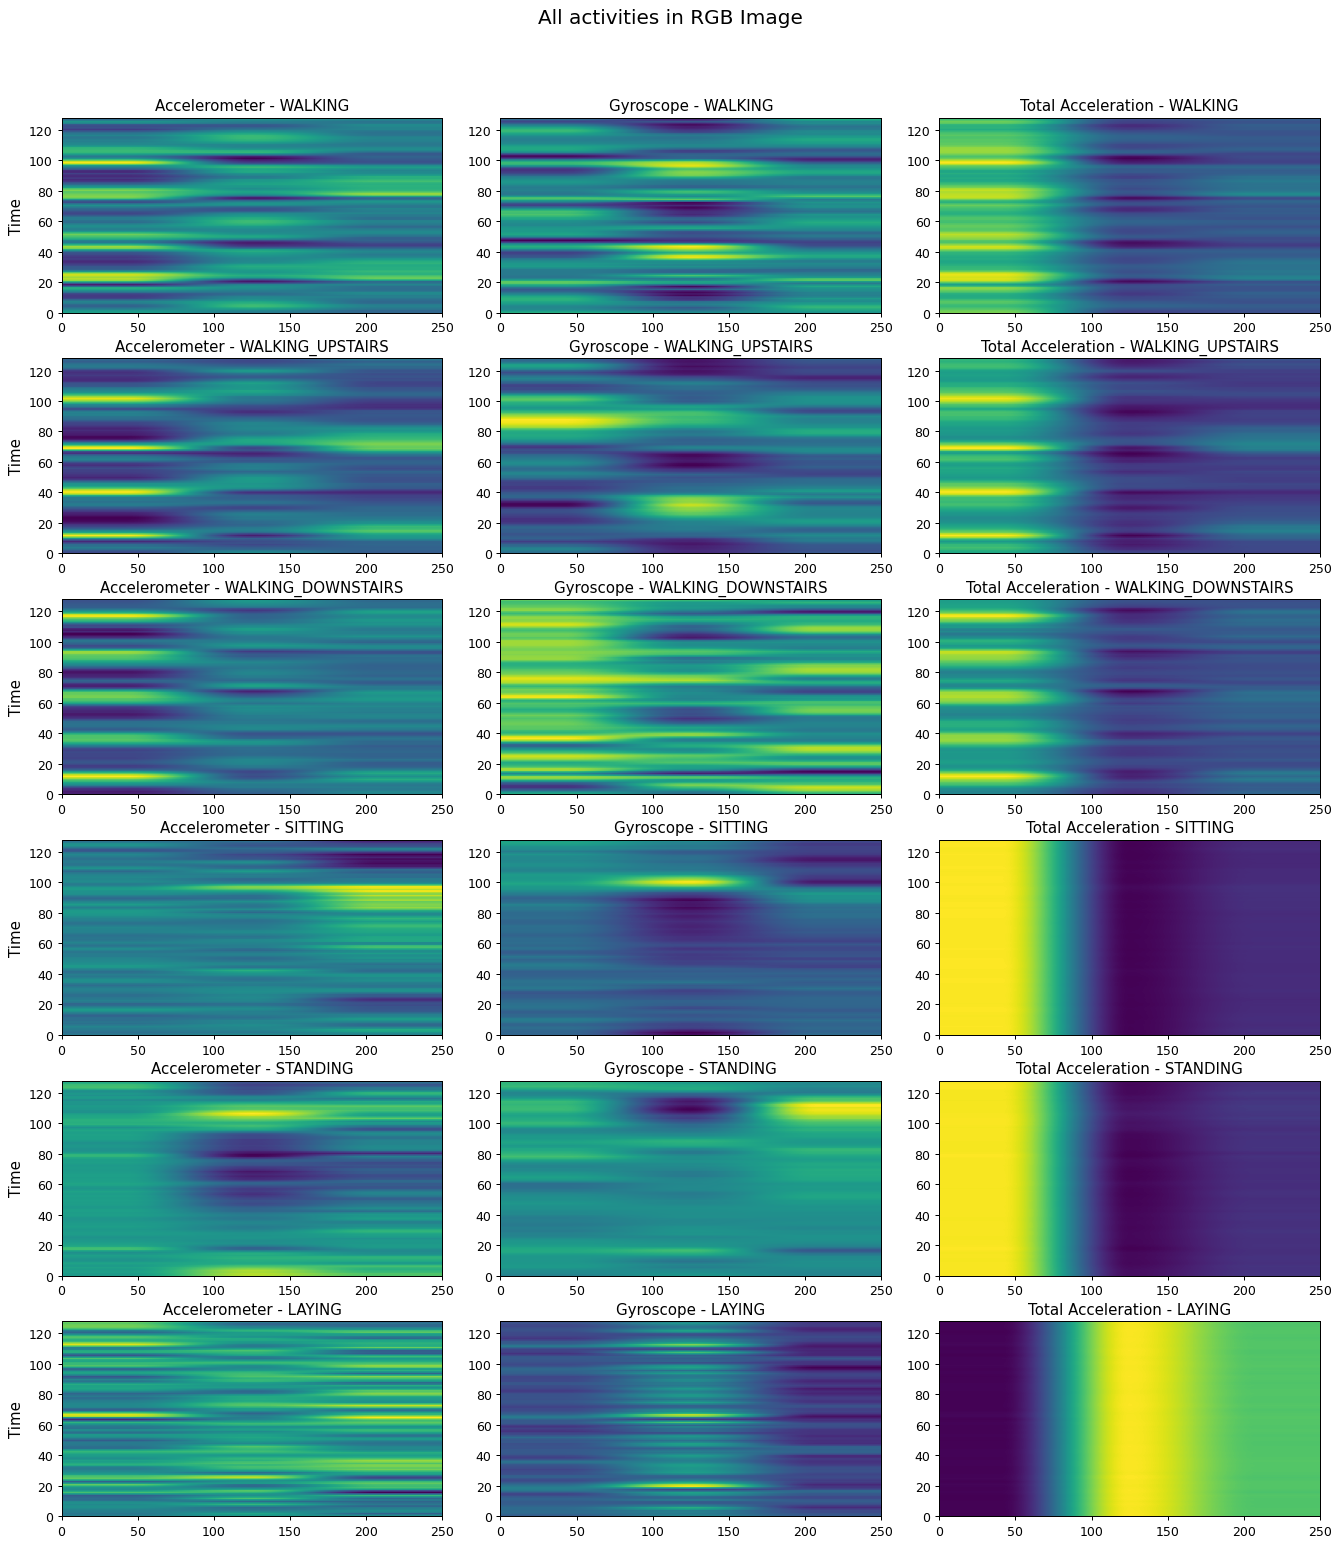

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import seaborn as sns

# Assuming you have train_data and train_labels loaded

# Define label map
label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
             4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

# Choose a random sample index for each activity
activity_indices = []
for i in range(6):
    for sample in range(1000):
        if train_labels[sample] == i + 1:
            activity_indices.append(sample)
            break

# Create RGB images
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 18))
fig.suptitle("All activities in RGB Image", fontsize=16)

for i, sample_index in enumerate(activity_indices):
    activity_label = label_map[i + 1]

    # Accelerometer Data - RGB Image
    axes[i, 0].set_title(f'Accelerometer - {activity_label}')
    red_channel = train_data[sample_index, :, 0]
    green_channel = train_data[sample_index, :, 1]
    blue_channel = train_data[sample_index, :, 2]
    image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    axes[i, 0].imshow(image, extent=(0, 250, 0, image.shape[0]))
    axes[i, 0].set_ylabel('Time')

    # Gyroscope Data - RGB Image
    axes[i, 1].set_title(f'Gyroscope - {activity_label}')
    red_channel = train_data[sample_index, :, 3]
    green_channel = train_data[sample_index, :, 4]
    blue_channel = train_data[sample_index, :, 5]
    image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    axes[i, 1].imshow(image, extent=(0, 250, 0, image.shape[0]))

    # Total Acceleration - RGB Image
    axes[i, 2].set_title(f'Total Acceleration - {activity_label}')
    red_channel = train_data[sample_index, :, 6]
    green_channel = train_data[sample_index, :, 7]
    blue_channel = train_data[sample_index, :, 8]
    image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    axes[i, 2].imshow(image, extent=(0, 250, 0, image.shape[0]))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
train_data

In [ ]:
train_data.shape,  test_data.shape

((7352, 128, 9), (2947, 128, 9))

In [ ]:
train_labels

array([4, 5, 5, ..., 6, 4, 2])

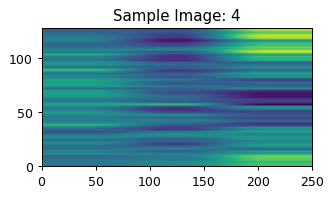

In [ ]:
red_channel = train_data[100, :, 0]
green_channel = train_data[100, :, 1]
blue_channel = train_data[100, :, 2]
image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
plt.figure(figsize=(10, 2))  # Adjust desired zoom level here
plt.imshow(image, extent=(0, 250, 0, image.shape[0]))
plt.title(f'Sample Image: {train_labels[100]}')
plt.show()


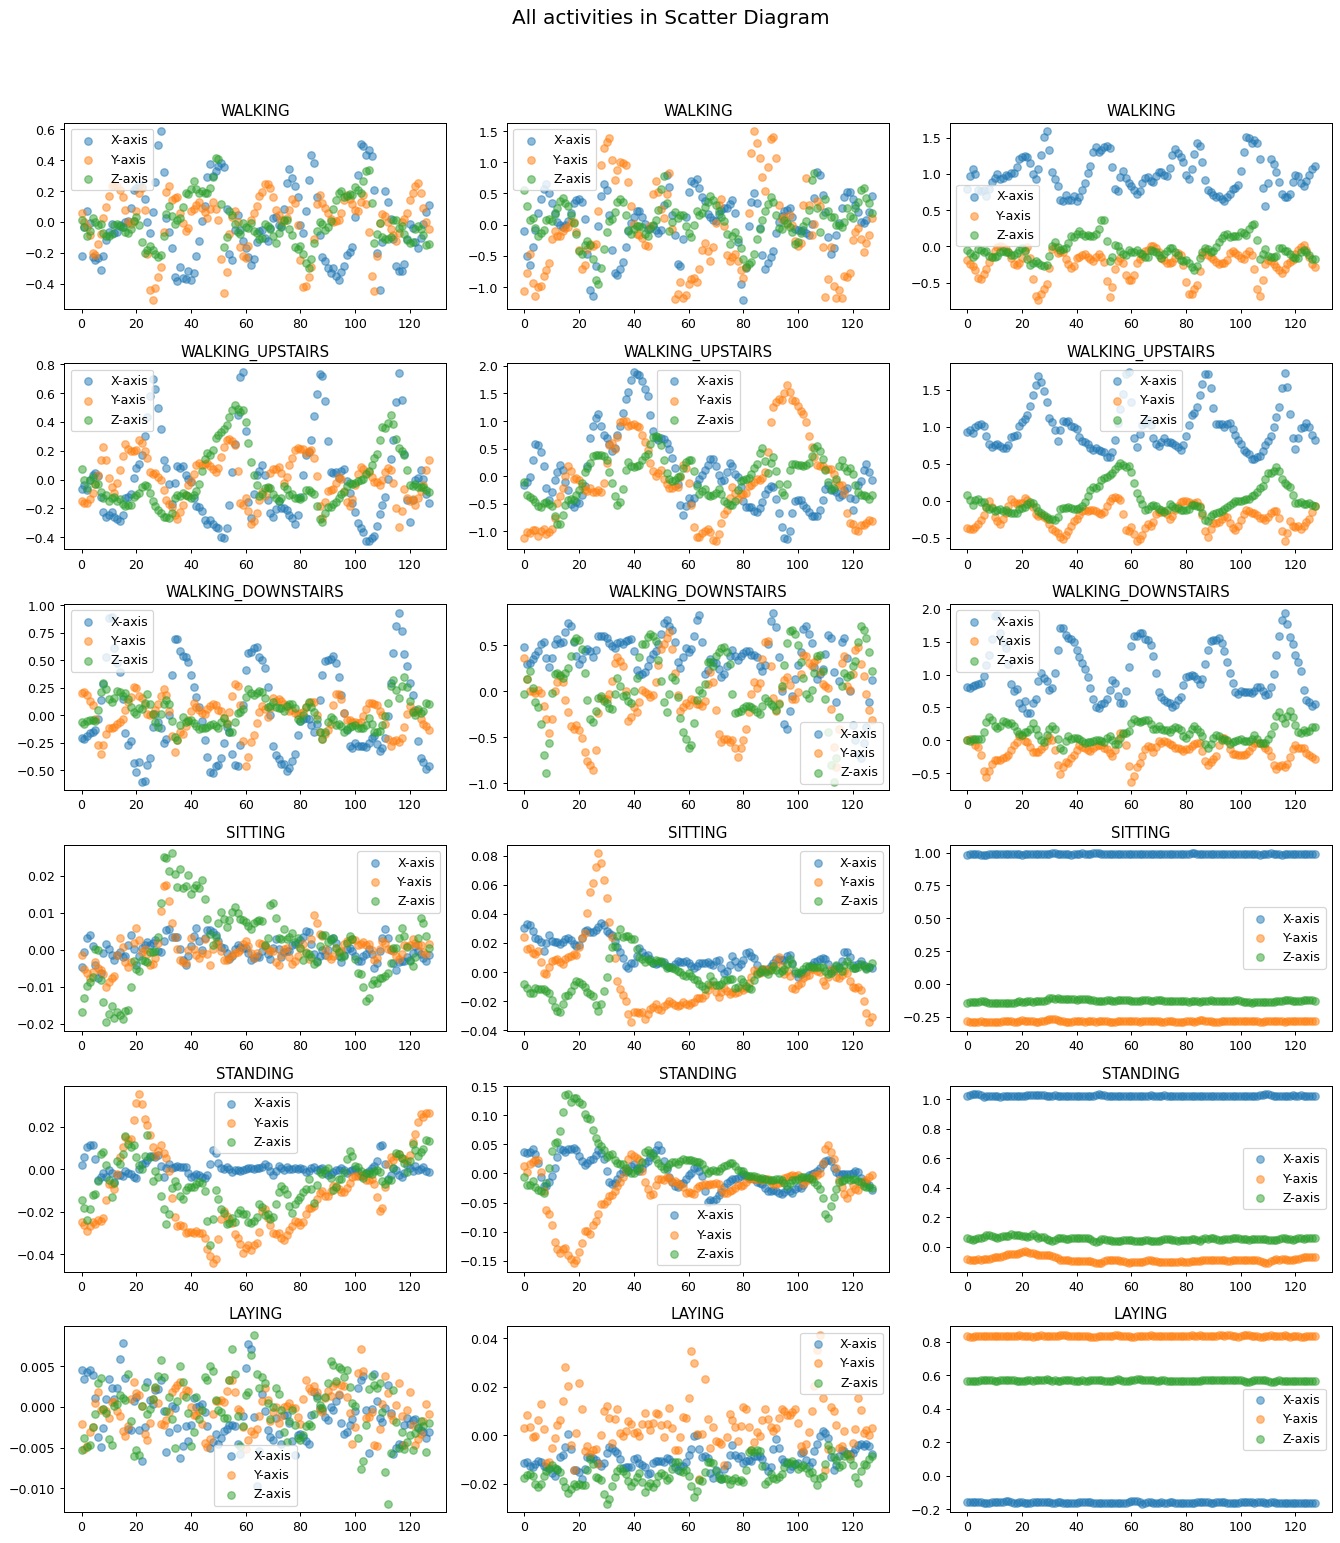

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have train_data and train_labels loaded

# Define label map
label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
             4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

# Choose a random sample index for each activity
activity_indices = []
for i in range(6):
    for sample in range(1000):
        if train_labels[sample] == i + 1:
            activity_indices.append(sample)
            break

# Create scatter plots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 18))

# Set central title
fig.suptitle("All activities in Scatter Diagram", fontsize=16)

for i, sample_index in enumerate(activity_indices):
    activity_label = label_map[i + 1]

    # Accelerometer Data - Scatter Plot
    axes[i, 0].set_title(f'{activity_label}')
    axes[i, 0].scatter(range(len(train_data[sample_index, :, 0])), train_data[sample_index, :, 0], label='X-axis', alpha=0.5)
    axes[i, 0].scatter(range(len(train_data[sample_index, :, 1])), train_data[sample_index, :, 1], label='Y-axis', alpha=0.5)
    axes[i, 0].scatter(range(len(train_data[sample_index, :, 2])), train_data[sample_index, :, 2], label='Z-axis', alpha=0.5)
    axes[i, 0].legend()

    # Gyroscope Data - Scatter Plot
    axes[i, 1].set_title(f'{activity_label}')
    axes[i, 1].scatter(range(len(train_data[sample_index, :, 3])), train_data[sample_index, :, 3], label='X-axis', alpha=0.5)
    axes[i, 1].scatter(range(len(train_data[sample_index, :, 4])), train_data[sample_index, :, 4], label='Y-axis', alpha=0.5)
    axes[i, 1].scatter(range(len(train_data[sample_index, :, 5])), train_data[sample_index, :, 5], label='Z-axis', alpha=0.5)
    axes[i, 1].legend()

    # Total Acceleration - Scatter Plot
    axes[i, 2].set_title(f'{activity_label}')
    axes[i, 2].scatter(range(len(train_data[sample_index, :, 6])), train_data[sample_index, :, 6], label='X-axis', alpha=0.5)
    axes[i, 2].scatter(range(len(train_data[sample_index, :, 7])), train_data[sample_index, :, 7], label='Y-axis', alpha=0.5)
    axes[i, 2].scatter(range(len(train_data[sample_index, :, 8])), train_data[sample_index, :, 8], label='Z-axis', alpha=0.5)
    axes[i, 2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate central title
plt.show()


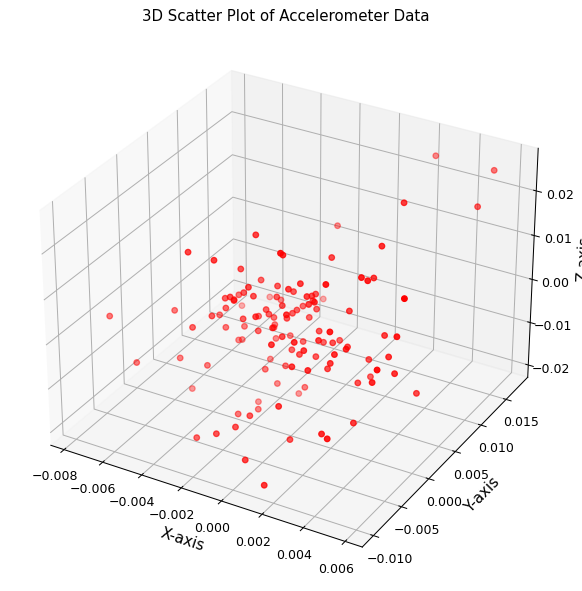

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

accel_data = train_data[sample_index, :, :3]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(accel_data[:, 0], accel_data[:, 1], accel_data[:, 2], c='r', marker='o')

ax.set_title('3D Scatter Plot of Accelerometer Data')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()


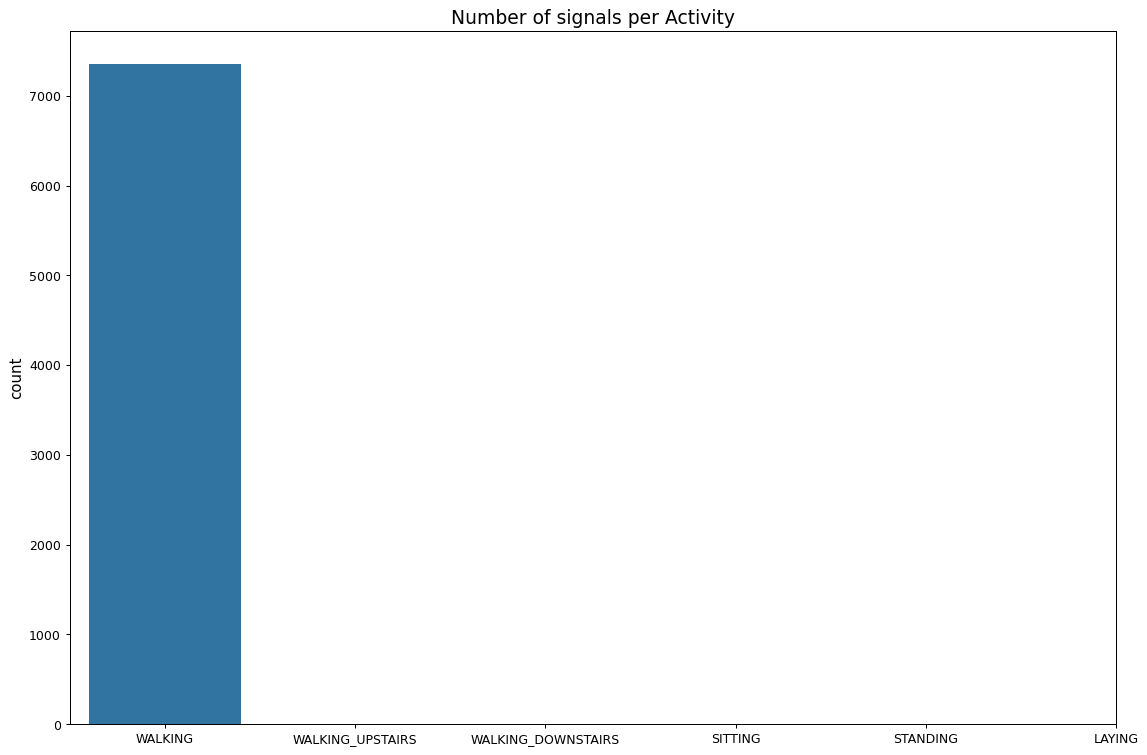

In [ ]:
# distribution of training data


plt.figure(figsize=(15,10))
label_map = {1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}
plt.title('Number of signals per Activity', fontsize=15)
sns.countplot(train_labels)
plt.xticks(ticks = list(range(0,6)),labels = label_map.values())
plt.show()

In [ ]:
#defining functions to extract different features
def get_features(y,T,N,fs,feature_type = 'signal'):
    if feature_type == 'signal':
        x = [1/fs * k for k in range(0,len(y))]
        return x,y
    elif feature_type == 'fft':
        f_values_ = fftfreq(N,d = 1/fs)
        f_values = f_values_[0:N//2]
        fft_values_ = fft(y)
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
        return f_values, fft_values
    elif feature_type == 'autocorr':
        a_values = np.correlate(y, y, mode='full')
        a_values = a_values[len(a_values)//2:]
        x = np.array([T * k for k in range(0, N)])
        return x, a_values
    elif feature_type == 'psd':
        f_values, psd_values = welch(y, fs)
        return f_values, psd_values
    else:
        raise ValueError("Wrong feature")


In [ ]:
#data info

N = 128 # 128 readings in each window
fs = 50 # sampling frequency
t = 2.56 #fixed width sliding window
ts = 1/fs #sampling period
T = t/N #time per reading

In [ ]:
# Visualization of signals

sig_num = 15
sigs = train_data[sig_num,:,:]
sig = sigs[:,3]
label = train_labels[sig_num]
activity = label_map[label]


In [ ]:
# Visualization of signal characteristics
fig, axs = plt.subplots(4,1,figsize = (15,20))
x,y = get_features(sig,T,N,fs,feature_type = 'signal')
f_val,fft_values = get_features(sig,T,N,fs,feature_type = 'fft')
xues, autocorr_values = get_features(sig,T,N,fs,feature_type = 'autocorr')
f_values,psd_values = get_features(sig,T,N,fs,feature_type = 'psd')
axs[0].plot(x, y, linestyle='-', color='black')
axs[0].set(xlabel = 'Time [sec]',ylabel = "Amplitude", title = "Measurement Signal")
axs[0].grid()
axs[1].plot(f_val, fft_values, linestyle='-', color='blue')
axs[1].set(xlabel = 'Frequency [Hz]', ylabel = "Amplitude", title = "Measurement signal in frequency domain")
axs[1].grid()
axs[2].plot(xues, autocorr_values, linestyle='-', color='red')
axs[2].set(xlabel = 'Time lag [s]', ylabel = "Amplitude", title = "Autocorrelation of measurement signal")
axs[2].grid()
axs[3].plot(f_values, psd_values, linestyle='-', color='green')
axs[3].set(xlabel = 'Frequency [Hz]', ylabel = 'PSD', title = "Power spectral density of measurment signal")
axs[3].grid()
fig.suptitle("Signal and its features",fontsize = 20)
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
suptitle = "Measurement signals for {}"
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]
feature = ['signal','fft','autocorr','psd']

fig,axs = plt.subplots(4,3,figsize =(14,12),dpi = 300)
for r in range(0,4):
    for comp in range(0,9):
        c = comp//3
        p = comp % 3
        color = colors[p]
        label = labels[p]

        axtitle = axtitles[r][c]
        xlabel = xlabels[r]
        ax = axs[r,c]
        ax.set(xlabel = xlabel, ylabel = ylabel, title = axtitle)
        if c == 0:
            ax.set_ylabel(ylabel,fontsize=16)
        sig = sigs[:,comp]
        x,y = get_features(sig,T,N,fs,feature_type = feature[r])
        ax.plot(x,y,linestyle='-', color=color, label=label)
        ax.grid()
        if r > 0: #find peak only for features
            min_peak_height = 0.1*np.nanmax(y) #max peak height
            i_peaks,_ = find_peaks(y,height = min_peak_height)
            ax.scatter(x[i_peaks],y[i_peaks],c=color,marker='o',s=60)
        if c == 2:
            ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.6)
fig.suptitle(suptitle.format(str.lower(activity)), fontsize=18,fontweight = 'bold')
plt.show()


In [ ]:
# prompt: see the measurements signals for walking. code present in the above cell. as similar this, write code for measurement signal for laying

sig_num = 10
sigs = train_data[sig_num,:,:]
sig = sigs[:,3]
label = train_labels[sig_num]
activity = label_map[label]

# Visualization of signal characteristics
fig, axs = plt.subplots(4,1,figsize = (15,20))
x,y = get_features(sig,T,N,fs,feature_type = 'signal')
f_val,fft_values = get_features(sig,T,N,fs,feature_type = 'fft')
xues, autocorr_values = get_features(sig,T,N,fs,feature_type = 'autocorr')
f_values,psd_values = get_features(sig,T,N,fs,feature_type = 'psd')
axs[0].plot(x, y, linestyle='-', color='black')
axs[0].set(xlabel = 'Time [sec]',ylabel = "Amplitude", title = "Measurement Signal")
axs[0].grid()
axs[1].plot(f_val, fft_values, linestyle='-', color='blue')
axs[1].set(xlabel = 'Frequency [Hz]', ylabel = "Amplitude", title = "Measurement signal in frequency domain")
axs[1].grid()
axs[2].plot(xues, autocorr_values, linestyle='-', color='red')
axs[2].set(xlabel = 'Time lag [s]', ylabel = "Amplitude", title = "Autocorrelation of measurement signal")
axs[2].grid()
axs[3].plot(f_values, psd_values, linestyle='-', color='green')
axs[3].set(xlabel = 'Frequency [Hz]', ylabel = 'PSD', title = "Power spectral density of measurment signal")
axs[3].grid()
fig.suptitle("Signal and its features",fontsize = 20)
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
def get_xypeaks(x,y, mph, npeaks = 2):
    '''
    returns top n peaks
    '''
    ind,_ = find_peaks(y,height = mph)
    peak_x,peak_y = list(x[ind]),list(y[ind])
    if len(peak_x) >= npeaks:
        peaks_x,peaks_y = peak_x[:npeaks],peak_y[:npeaks]
    else :
        pad = npeaks - len(peak_x)
        peaks_x,peaks_y = peak_x+[0]*pad, peak_y+[0]*pad
    return peaks_y

In [ ]:
def prepare_dataset(data,labels,T,N,fs):
    feature_list = []
    label_list = []
    percentile = 5
    for n in range(len(data)):
        label_list.append(labels[n])
        features = []
        for comp in range(0,data.shape[2]):
            signal = data[n,:,comp]
            mph = 0.1*np.nanmax(signal) #minimum peak height threshold
            features += get_xypeaks(*get_features(signal, T, N, fs,feature_type = 'fft'),mph,npeaks = 3)
            features += get_xypeaks(*get_features(signal, T, N, fs,feature_type = 'psd'),mph,npeaks = 3)
            features += get_xypeaks(*get_features(signal, T, N, fs,feature_type = 'autocorr'),mph,npeaks = 3) #9*3*2*3
        feature_list.append(features)
    return np.array(feature_list),np.array(label_list)


In [ ]:
Xtrain,ytrain = prepare_dataset(train_data,train_labels,T,N,fs)
Xtest,ytest = prepare_dataset(test_data,test_labels,T,N,fs)

In [ ]:
m = np.mean(Xtrain, axis=0) # array([16.25, 26.25])
std = np.std(Xtrain, axis=0) # array([17.45530005, 22.18529919])
md = np.median(Xtrain,axis = 0)
p75 = np.percentile(Xtrain,75,axis = 0)
p25 = np.percentile(Xtrain,25,axis = 0)
Xtrainn = np.tanh((Xtrain - md) + 0.00005 / (p75 - p25)) #normalization and feature scaling for train set
Xtestn = np.tanh((Xtest - md) + 0.00005 / (p75 - p25)) #normalization and feature scaling for test set
# scaler = MinMaxScaler(feature_range=(-1, 1))
# Xtrain_n = scaler.fit_transform(Xtrain)
# Xtest_n = scaler.transform(Xtest)

In [ ]:
n_features = Xtrain.shape[1]
ncomp = int(np.floor(0.4*n_features))
pca = PCA(ncomp)
pca.fit(Xtrainn)
Xtrainp = pca.transform(Xtrainn)
Xtestp = pca.transform(Xtestn)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(40, c='b',linestyle = '--')
plt.axhline(0.98,c='r',ls = '--')
plt.show();